# Plot and annotate LEV-1 CW

Tammo Jan Dijkema, 19 September 2024

In [ ]:
%matplotlib inline
from datetime import datetime, timedelta, timezone

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from matplotlib.dates import num2date

matplotlib.rcParams["date.autoformatter.hour"] = "%H:%M"
matplotlib.rcParams["date.autoformatter.minute"] = "%H:%M"
from glob import glob

import astropy.units as u
import ipywidgets
from astropy.time import Time

In [ ]:
for keymap in """keymap.back
keymap.copy
keymap.forward
keymap.fullscreen
keymap.grid
keymap.grid_minor
keymap.help
keymap.home
keymap.pan
keymap.quit
keymap.quit_all
keymap.save
keymap.xscale
keymap.yscale
keymap.zoom""".split():
    plt.rcParams[keymap] = []

In [ ]:
class Annotator:
    def __init__(self, ax, annotations=None):
        self.ax = ax
        if annotations is None:
            self.annotations = []
        else:
            self.annotations = annotations
        self.annotation_text = ipywidgets.Text(description="Annotation:")
        self.button_submit = ipywidgets.Button(description="Submit")
        self.button_submit.on_click(self.submit_annotation)
        self.container = ipywidgets.VBox([self.annotation_text, self.button_submit])
        display(self.container)
        for x, key in self.annotations:
            self.ax.annotate(key, (x, 0.6), fontsize=16, fontweight="bold", ha="center")
        self.active_point = None
        self.cid = ax.figure.canvas.mpl_connect("button_press_event", self)
        self.cid2 = ax.figure.canvas.mpl_connect("key_press_event", self.on_key_press)

    def __call__(self, event):
        if event.inaxes != self.ax:
            return
        self.x, self.y = event.xdata, event.ydata
        self.highlight_active_point()

    def highlight_active_point(self):
        if self.active_point:
            self.active_point.remove()
        self.active_point = self.ax.scatter(self.x, self.y, color="red")
        self.ax.figure.canvas.draw()

    def submit_annotation(self, button):
        key = self.annotation_text.value
        was_update = False
        for annotation in self.annotations:
            if np.abs(num2date(self.x) - annotation[0]).total_seconds() < 0.5:
                annotation[1] = key.upper()
                was_update = True
                break
        if not was_update:
            self.annotations.append([num2date(self.x), key.upper()])
        self.ax.annotate(
            key, (self.x, 0.6), fontsize=16, fontweight="bold", ha="center"
        )
        self.highlight_active_point()

    def on_key_press(self, event):
        key = event.key.upper()
        if not key.isalnum() or len(key) > 1:
            return
        was_update = False
        for annotation in self.annotations:
            if np.abs(num2date(self.x) - annotation[0]).total_seconds() < 0.5:
                annotation[1] = key.upper()
                was_update = True
                break
        if not was_update:
            self.annotations.append([num2date(self.x), key.upper()])
        self.ax.annotate(
            key, (self.x, 0.6), fontsize=16, fontweight="bold", ha="center"
        )
        self.highlight_active_point()

In [ ]:
def open_file(fname, cutoff=None):
    x = np.fromfile(fname, "float32")
    z = np.zeros_like(x) * np.nan
    if cutoff is None:
        cutoff = np.mean(x)
    z[x < cutoff] = -0.3
    duration_seconds = len(x) / 400
    start_time = datetime.strptime(fname[5:24], "%Y-%m-%d_%H_%M_%S")
    return start_time, duration_seconds, x, z

In [ ]:
def make_plot(start_time, duration_seconds, x, z):
    times = Time(start_time) + np.linspace(0, duration_seconds, len(x)) * u.s
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(times.datetime, x, ",-", color="lightgray", linewidth=0.5)
    if z is not None:
        ax.plot(times.datetime, z, ",-", color="black")
    return ax

In [ ]:
sorted(glob("slim_*f32"))

['slim_2024-01-19_15_28_29_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32',
 'slim_2024-01-19_15_39_58_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32',
 'slim_2024-01-19_15_49_46_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32',
 'slim_2024-01-19_16_25_47_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32',
 'slim_2024-01-19_16_37_49_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32']

In [ ]:
fname = "slim_2024-01-19_16_37_49_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"

In [ ]:
def read_annotations(fname):
    with open(fname + ".decoded.txt", "r") as f:
        for line in f:
            date, time, key = line.split()
            datestr = "T".join([date, time.replace("+", ".")])
            if len(datestr) != 19:
                datestr += "0"
            annotations.append(
                [datetime.fromisoformat(datestr).replace(tzinfo=timezone.utc), key]
            )
    return annotations

In [ ]:
annotations = read_annotations(fname)

Use the widget controls to zoom the plot in the horizontal directions. Click on a waveform and press the letter that matches it.

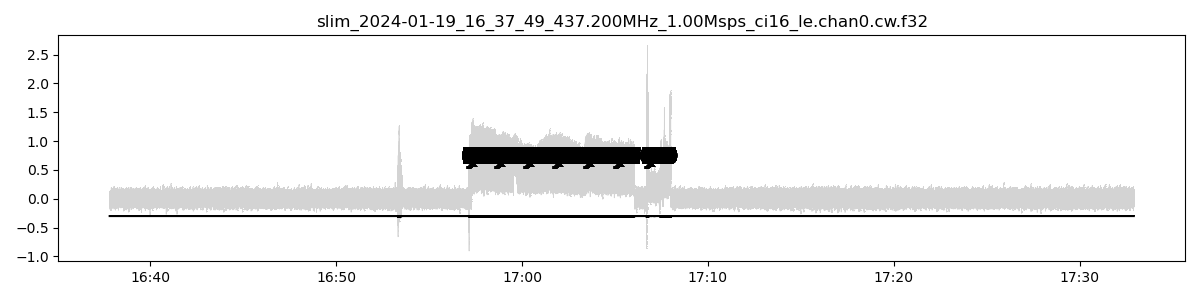

In [ ]:
%matplotlib widget
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
make_plot(start_time, duration_seconds, x, z)
plt.gca().set_title(fname)
annotator = Annotator(plt.gca(), annotations=annotations)
plt.tight_layout()

In [ ]:
if False:  # Prevent accidentally overwriting a file
    with open(fname + ".decoded.txt", "w") as f:
        for a in sorted(annotator.annotations, key=lambda a: a[0]):
            print(f"{str(a[0])[:22]} {a[1].strip()}", file=f)
            print(a[1].strip(), end="")
            if a[1] == "K":
                print()

# Some interesting parts

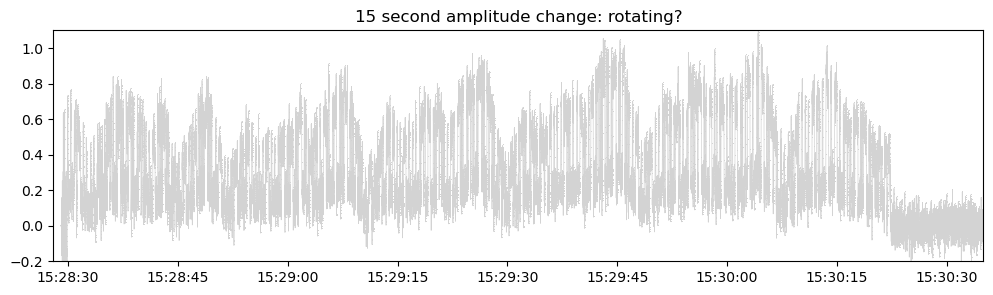

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_15_28_29_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 15, 28, 28), datetime(2024, 1, 19, 15, 30, 35))
ax.set_title("15 second amplitude change: rotating?");
ax.set_ylim(-0.2, 1.1);

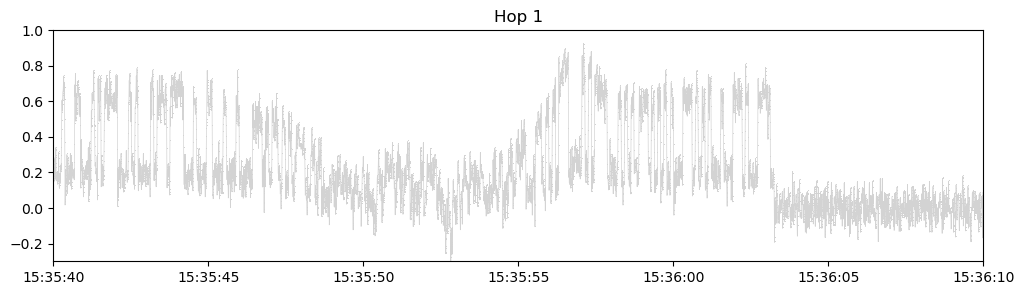

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_15_28_29_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 15, 35, 40), datetime(2024, 1, 19, 15, 36, 10))
ax.set_title("Hop 1");
ax.set_ylim(-0.3, 1.0);

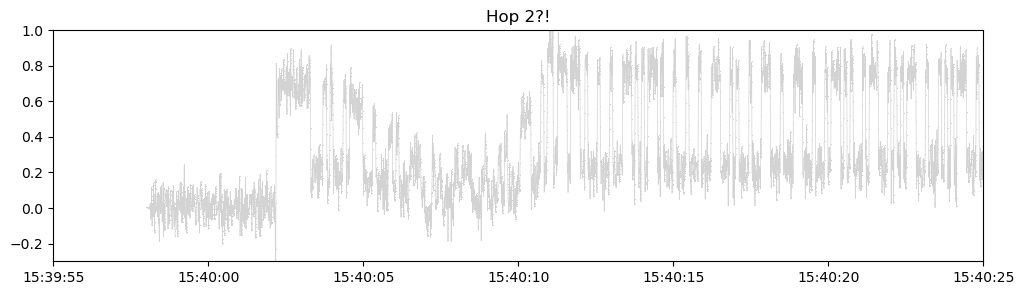

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_15_39_58_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 15, 39, 55), datetime(2024, 1, 19, 15, 40, 25))
ax.set_title("Hop 2?!");
ax.set_ylim(-0.3, 1.0);

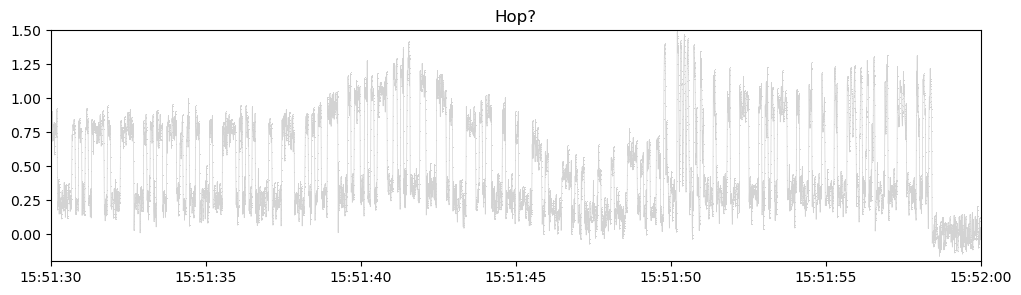

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_15_49_46_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 15, 51, 30), datetime(2024, 1, 19, 15, 52, 0))
ax.set_title("Hop?");
ax.set_ylim(-0.2, 1.5);

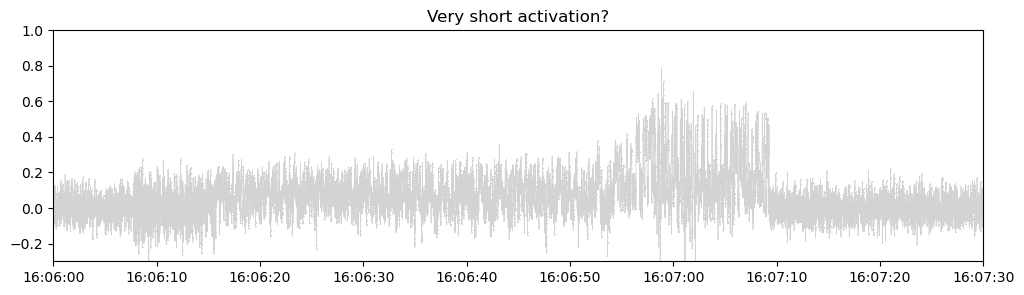

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_15_49_46_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 16, 6, 0), datetime(2024, 1, 19, 16, 7, 30))
ax.set_title("Very short activation?");
ax.set_ylim(-0.3, 1.0);

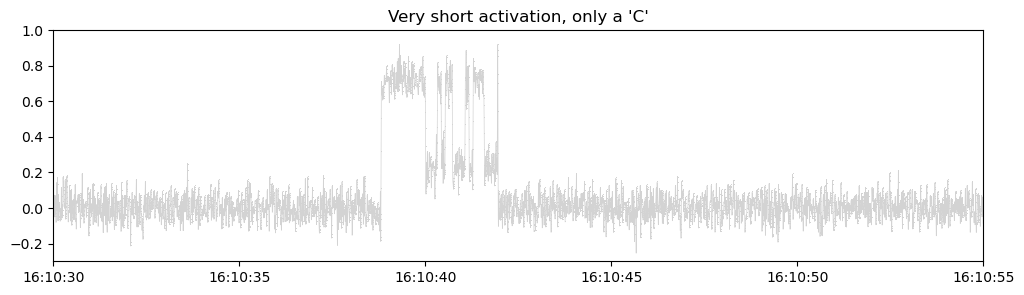

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_15_49_46_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 16, 10, 30), datetime(2024, 1, 19, 16, 10, 55))
ax.set_title("Very short activation, only a 'C'");
ax.set_ylim(-0.3, 1.0);

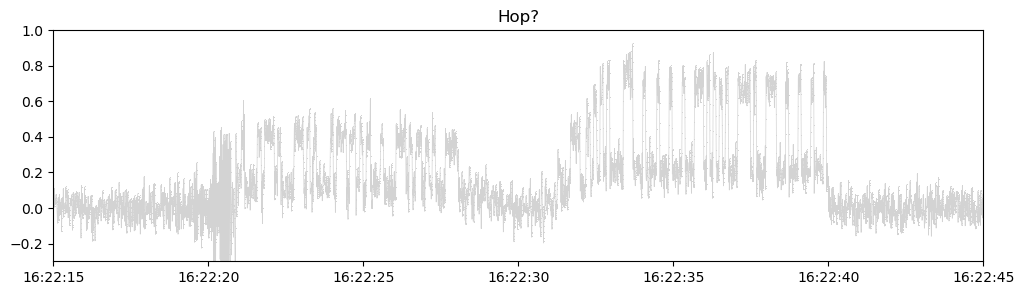

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_15_49_46_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 16, 22, 15), datetime(2024, 1, 19, 16, 22, 45))
ax.set_title("Hop?");
ax.set_ylim(-0.3, 1.0);

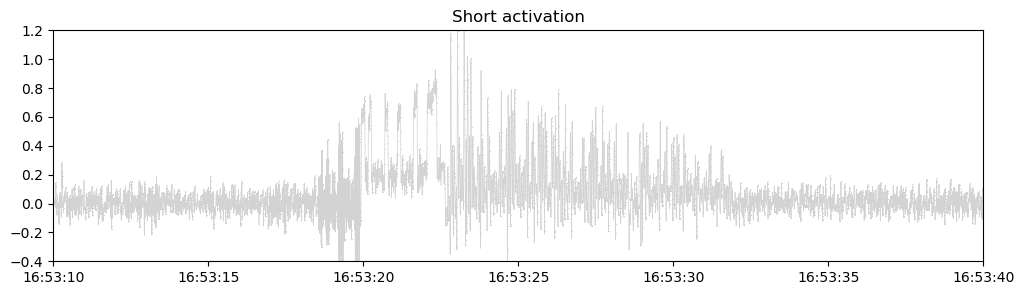

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_16_37_49_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 16, 53, 10), datetime(2024, 1, 19, 16, 53, 40))
ax.set_title("Short activation");
ax.set_ylim(-0.4, 1.2);

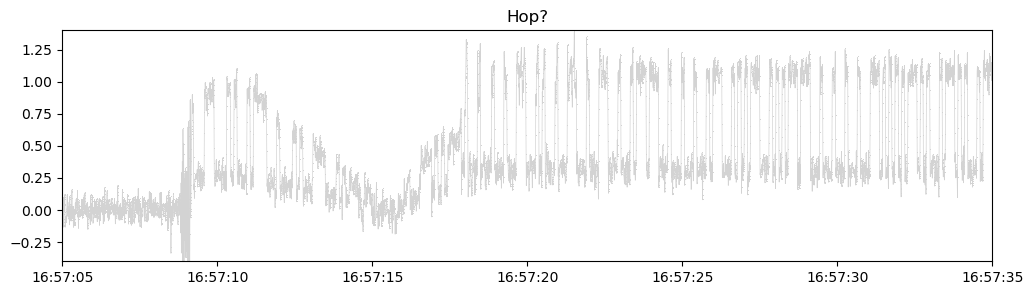

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_16_37_49_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 16, 57, 5), datetime(2024, 1, 19, 16, 57, 35))
ax.set_title("Hop?");
ax.set_ylim(-0.4, 1.4);

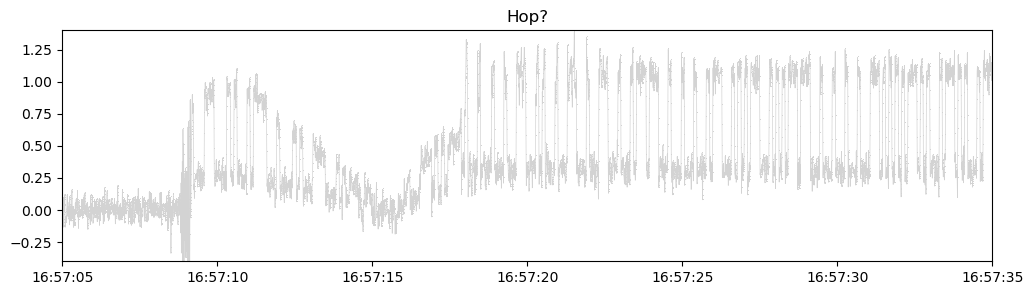

In [ ]:
%matplotlib inline
fname = "slim_2024-01-19_16_37_49_437.200MHz_1.00Msps_ci16_le.chan0.cw.f32"
start_time, duration_seconds, x, z = open_file(fname, cutoff=0.5)
ax = make_plot(start_time, duration_seconds, x, None)
annotations = read_annotations(fname)
ax.set_xlim(datetime(2024, 1, 19, 17, 6, 50), datetime(2024, 1, 19, 16, 57, 35))
ax.set_title("Hop?");
ax.set_ylim(-0.4, 1.4);

In [ ]:
"16:57:10", "16:22:25", "15:51:40", "15:40:02", "15:35:45"

('16:57:10', '16:22:25', '15:51:40', '15:40:02', '15:35:45')